In [1]:
# Input info
# noIn_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_30/"
# input_indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_30/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_30/"
# donor = 0
# noIn_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/noInput/knn/kparam_3"
# input_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/clones/results/inputOnly/knn/kparam_3"
# donor = 0
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor0/clones/knn_kparam_3"

# noIn_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/dendro_bc/results/noInput/knn/kparam_30"
# input_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/dendro_bc/results/inputOnly/knn/kparam_30"
# donor = 3
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clonal_shifts/variants_init/donors/donor3/dendro_bc/knn_kparam_30"


clone_col = "den_clust"


noIn_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clonal_shifts/variants_simpleUnion/clones/results/noInput/knn/kparam_30" 
input_indir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clonal_shifts/variants_simpleUnion/clones/results/inputOnly/knn/kparam_30"
donor = 0
clone_col = "name"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/objs_standard_constraints_None/clonal_shifts/variants_simpleUnion/donors/donor0/clones/knn_kparam_30"

# config
conditions = ["inputOnly", "noInput"]

# params
p_thresh = 0.1 

atac_col = "cluster_labels"
#clone_col = "name" #den_clust, "Variants", "den_clust"


In [2]:
from glob import glob
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
noIn_don_indir =  join(noIn_indir,"sepDonors", f"donor{donor}")
input_don_indir =  join(input_indir,"sepDonors", f"donor{donor}")


In [4]:
def load_shuffle(f):
    if exists(f):
        return pd.read_csv(f, sep="\t", index_col=0)
    else: 
        return pd.DataFrame(columns=["index","variable","value", "method"])

def load_hypergeo(f):
    if exists(f):
        return pd.read_csv(f, index_col=0)
    else: 
        return pd.DataFrame()

def load_ncells(ncells_f):
    if not exists(ncells_f):
        return pd.DataFrame(columns = ["clusterID","cloneID", "count", "log2_count"])
    else: 
        return pd.read_csv(ncells_f)
        
def copy_hypergeo_files(hypergeo_f, out_hypergeo_f):
    if not exists(hypergeo_f):
        pd.DataFrame().to_csv(out_hypergeo_f)
    else: 
        cmd = f"cp {hypergeo_f} {out_hypergeo_f}"
        os.system(cmd)
        

In [5]:
noInput_df = load_shuffle(join(noIn_don_indir, "shuffle_results_pvals.tsv"))
noInput_hyper = load_hypergeo(join(noIn_don_indir, "hypergeo_padjusted.csv"))
input_df = load_shuffle(join(input_don_indir, "shuffle_results_pvals.tsv"))
input_hyper = load_hypergeo(join(input_don_indir, "hypergeo_padjusted.csv"))

input_hyper

,0,1,2,3,4,5,6,7,8,10,11,12
0_0,0.262534,0.461940,0.642259,0.603502,0.090610,0.793344,0.504190,0.003796,0.975036,0.380201,0.733717,0.003796
0_10,0.748131,0.361812,0.545036,0.587536,0.543444,0.265195,0.073368,0.077200,0.073368,0.324229,0.119422,0.077200
0_11,0.324229,0.461511,0.125261,0.173322,0.324229,0.639720,0.582093,0.094473,0.570847,0.363187,0.137919,0.094473
0_12,0.748131,0.361812,0.545036,0.101217,0.247742,0.265195,0.504190,0.077200,0.204850,0.324229,0.119422,0.077200
0_14,0.620043,0.077200,0.461511,0.490209,0.154069,0.461511,0.126129,0.073368,0.416295,0.272065,0.094473,0.073368
0_15,0.363187,0.315200,0.504190,0.246007,0.197620,0.504190,0.181221,0.077200,0.461511,0.313729,0.109695,0.077200
0_18,0.696229,0.315200,0.073368,0.543446,0.197620,0.504190,0.466288,0.077200,0.174446,0.313729,0.109695,0.077200
0_19,0.313729,0.548003,0.461511,0.490209,0.154069,0.461511,0.126129,0.073368,0.124840,0.272065,0.094473,0.073368
0_20,0.363187,0.617178,0.204650,0.077200,0.197620,0.504190,0.466288,0.077200,0.461511,0.313729,0.109695,0.077200
0_21,0.748131,0.073368,0.545036,0.587536,0.543444,0.265195,0.504190,0.077200,0.073368,0.324229,0.119422,0.077200


In [6]:

# if exists(noIn_f):
#     noInput_df = pd.read_csv(join(noIn_don_indir, "shuffle_results_pvals.tsv"), sep="\t", index_col=0)
# else: 
#     noInput_df = pd.DataFrame(columns=["index","variable","value", "method"])
    
# noIn_hyper_f = join(noIn_don_indir, "hypergeo_padjusted.csv")
# if exists(noIn_hyper_f):
#     noInput_hyper = pd.read_csv(noIn_hyper_f,  index_col=0)
#     noInput_hyper = pd.DataFrame()


# input_f = join(input_don_indir, "shuffle_results_pvals.tsv")
# if exists(input_f):
#     input_df = pd.read_csv(input_f, sep="\t", index_col=0)
#     print(input_df)
# input_hyper_f = join(input_don_indir, "hypergeo_padjusted.csv")
# if exists(input_hyper_f):
#     input_hyper = pd.read_csv(input_hyper_f,  index_col=0)
#     print(input_hyper)

In [7]:
copy_hypergeo_files(join(input_don_indir, "hypergeo_padjusted.csv"), 
                    join(outdir, "input_hypergeo_padjusted.csv"))
copy_hypergeo_files(join(noIn_don_indir, "hypergeo_padjusted.csv"), 
                    join(outdir, "noInput_hypergeo_padjusted.csv"))

# in_input_adjHyper_f = join(input_don_indir, "hypergeo_padjusted.csv")
# out_input_adjHyper_f = join(outdir, "input_hypergeo_padjusted.csv")
# in_noInput_adjHyper_f = join(noIn_don_indir, "hypergeo_padjusted.csv")
# out_noInput_adjHyper_f = join(outdir, "noInput_hypergeo_padjusted.csv")
# cmd = f"cp {in_noInput_adjHyper_f} {out_noInput_adjHyper_f}"
# !{cmd}
# cmd = f"cp {in_input_adjHyper_f} {out_input_adjHyper_f}"
# !{cmd}

In [8]:
in_input_ncells_f = join(input_don_indir, 'ncells.csv')
out_input_ncells_f = join(outdir, 'input_ncells.csv')
in_noInput_ncells_f = join(noIn_don_indir, 'ncells.csv')
out_noInput_ncells_f = join(outdir, 'noInput_ncells.csv')

# in_ncells = pd.read_csv(in_input_ncells_f)
# noIn_ncells = pd.read_csv(in_noInput_ncells_f)
in_ncells = load_ncells(in_input_ncells_f)
noIn_ncells = load_ncells(in_noInput_ncells_f)

in_ncells.rename({atac_col:"clusterID", clone_col:"cloneID"}, axis=1).to_csv(out_input_ncells_f)
noIn_ncells.rename({atac_col:"clusterID", clone_col:"cloneID"}, axis=1).to_csv(out_noInput_ncells_f)




In [9]:
set(input_hyper.index) - set(noInput_hyper.index)
set(noInput_hyper.index) - set(input_hyper.index) 

set()

In [10]:
all_clones = set(noInput_hyper.index).union(set(input_hyper.index) )
all_clones

{'0_0',
 '0_10',
 '0_11',
 '0_12',
 '0_14',
 '0_15',
 '0_18',
 '0_19',
 '0_20',
 '0_21',
 '0_22',
 '0_23',
 '0_24',
 '0_25',
 '0_27',
 '0_28',
 '0_29',
 '0_30',
 '0_33',
 '0_34',
 '0_4',
 '0_5',
 '0_6',
 '0_8',
 '0_9'}

{'0_25', '0_33', '0_23', '0_12', '0_18', '0_4', '0_28', '0_34', '0_19', '0_20', '0_11', '0_29', '0_15', '0_9', '0_8', '0_14', '0_0', '0_27', '0_5', '0_24', '0_21', '0_10', '0_30', '0_6', '0_22'}


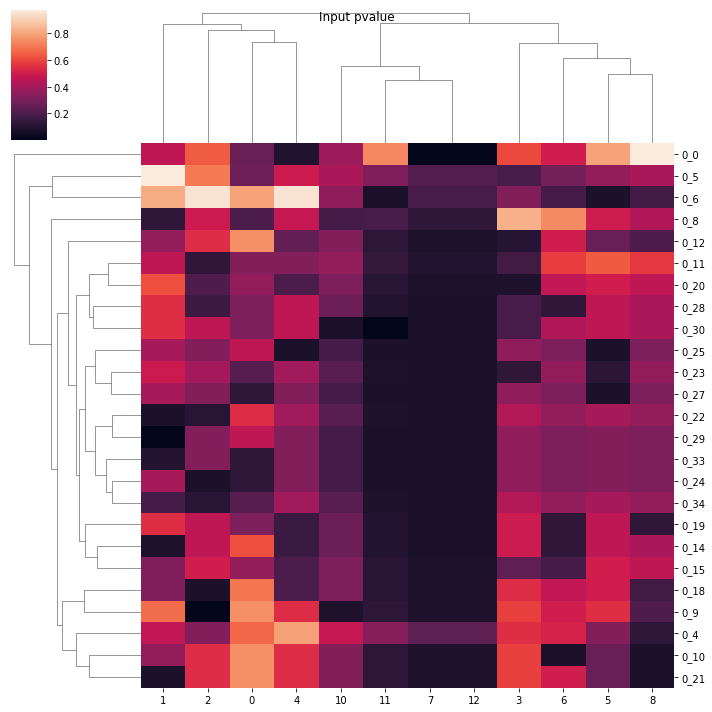

In [15]:
#noInput_hyper.loc[list(all_clones-set(noInput_hyper.index)),:] = 0
noInput_hyper = noInput_hyper.transpose()
if len(all_clones-set(noInput_hyper.columns)) != 0:
    noInput_hyper[list(all_clones-set(noInput_hyper.columns))] = 0
noInput_hyper = noInput_hyper.transpose()
input_hyper = input_hyper.transpose()
print(set(input_hyper.columns))
if len(list(all_clones-set(input_hyper.columns))) != 0:    
    print('here')
    print(list(all_clones-set(input_hyper.columns)))
    input_hyper.loc[:, list(all_clones-set(input_hyper.columns))] = 0
input_hyper = input_hyper.transpose()

#input_hyper.loc[all_clones-set(input_hyper.index),:] = 0
if input_hyper.shape[0]>1 and input_hyper.shape[1] > 1:
    g=sns.clustermap((input_hyper))
    g.fig.suptitle("Input pvalue")
    inds = g.dendrogram_row.dendrogram["leaves"]
    g.fig.savefig(join(outdir, f"input_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

# g=sns.clustermap(-np.log10(input_hyper))
# g.fig.suptitle("Input(-log 10 pvalue, 1 is p=0.1)")
# inds = g.dendrogram_row.dendrogram["leaves"]
# g.fig.savefig(join(outdir, f"input_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

#cols = g.dendrogram_col.dendrogram["leaves"]
# g2 = sns.clustermap(-np.log10(noInput_hyper.iloc[inds]), row_cluster=False)
# g2.fig.suptitle("Cultured (-log 10 pvalue, 1 is p=0.1)")


if noInput_hyper.shape[0]>1 and noInput_hyper.shape[1] > 1:
    g2 = sns.clustermap((noInput_hyper.iloc[inds]), row_cluster=False)
    g2.fig.suptitle("Cultured pvalue")

    g2.fig.savefig(join(outdir, f"cultured_hyper_padj.pdf"),dpi=300, bbox_inches = "tight")

In [16]:
# merge_pval = pd.merge(input_df.rename({"value":"p_val"}, axis=1), 
#                       noInput_df.rename({"value":"p_val"}, axis=1), on=["index", "variable", "method"], suffixes=["_input", "_cultured"])
# merge_pval
# merge_pval.to_csv(join(outdir, "shuffle_p_vals.csv"))

# save to combined directory
input_df.to_csv(join(outdir, "input_shuffle_results_pvals.csv"))
noInput_df.to_csv(join(outdir, "noInput_shuffle_results_pvals.csv"))
noInput_hyper.to_csv(join(outdir, "noInput_hypergeo_pvals.csv"))
input_hyper.to_csv(join(outdir, "input_hypergeo_pvals.csv"))

# noInput_hyper.reset_index().melt(id_vars=["index"], value_name="hyper_pval").to_csv(join(outdir, "noInput_hypergeo_pvals.csv"))
# input_hyper.reset_index().melt(id_vars=["index"], value_name="hyper_pval").to_csv(join(outdir, "input_hypergeo_pvals.csv"))


## Get overlapping clones and clusters and use same clone indices from input to noInput

clone_all


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:709: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


clone_min
global_all
global_min


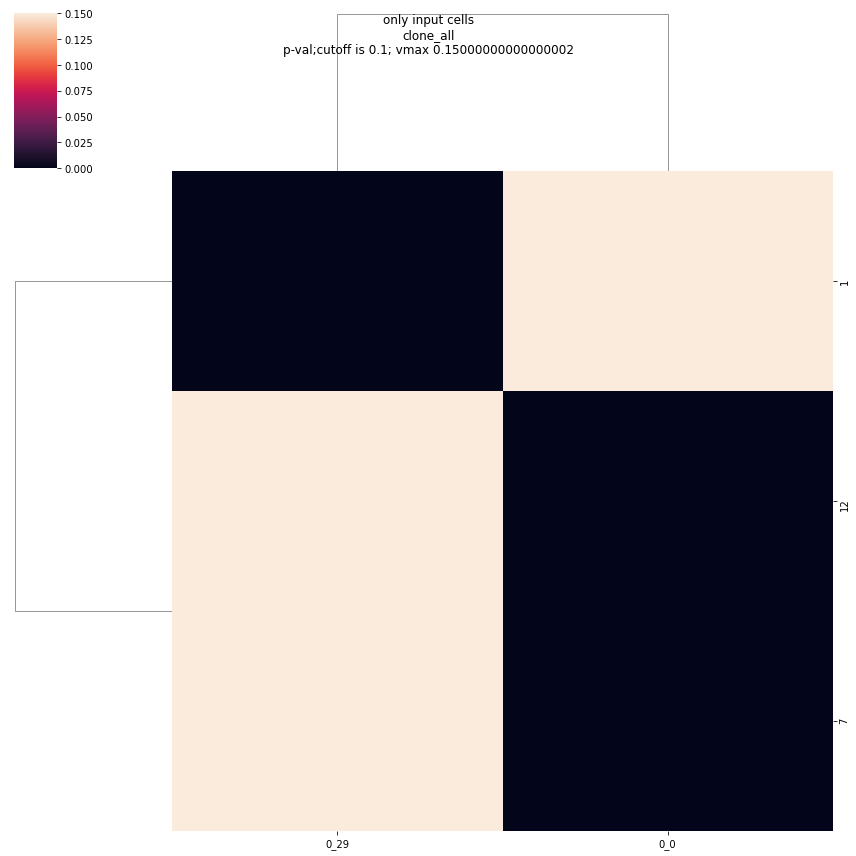

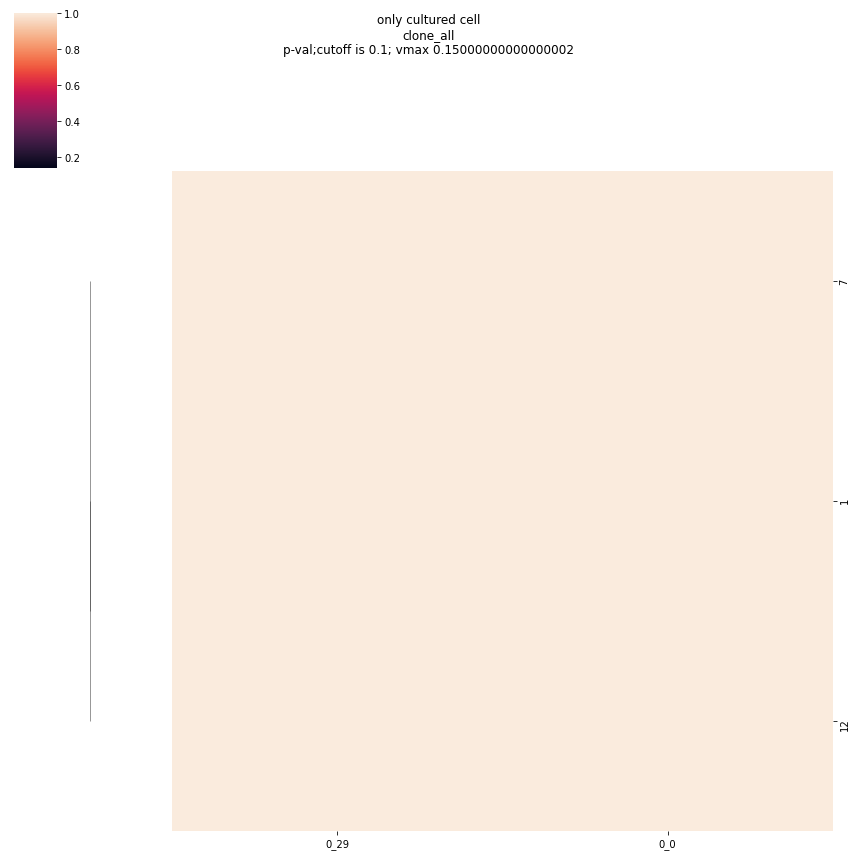

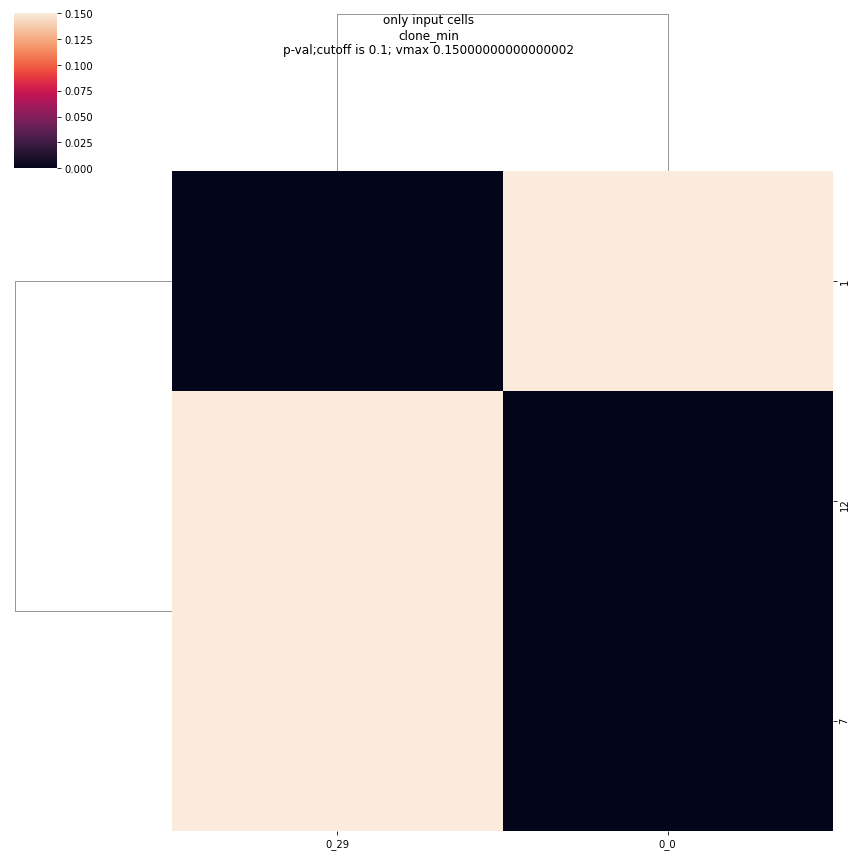

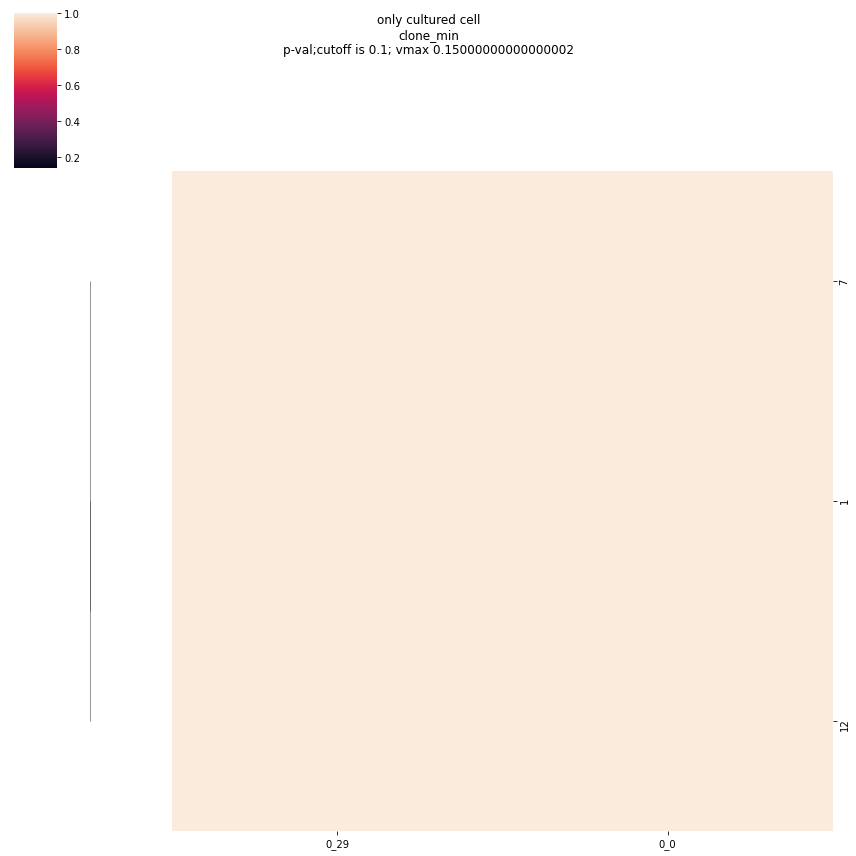

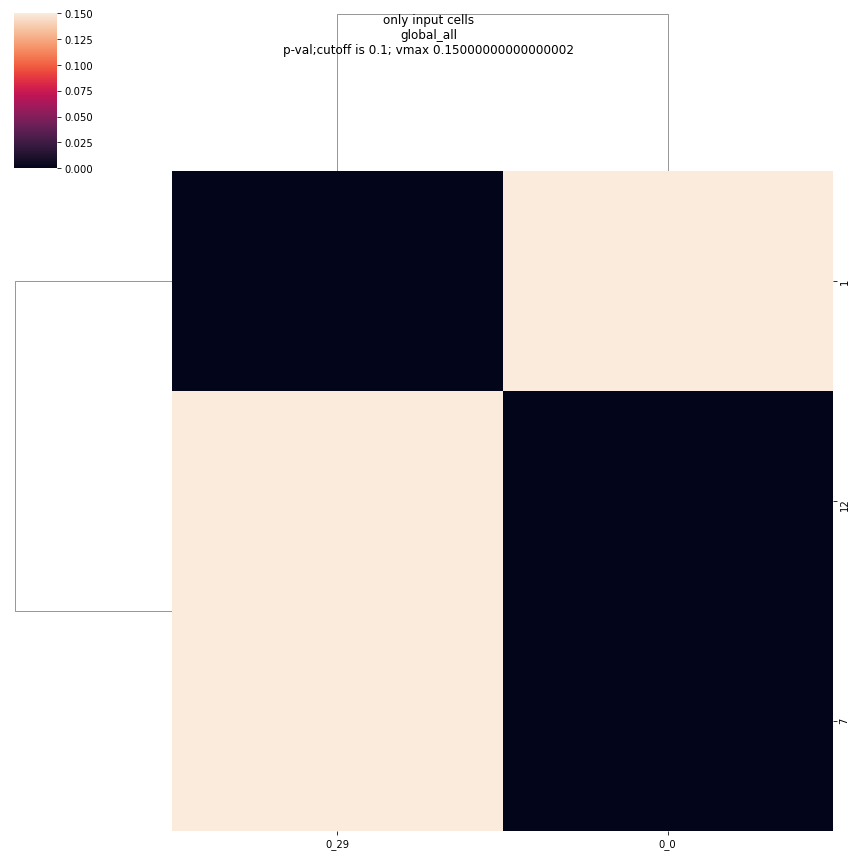

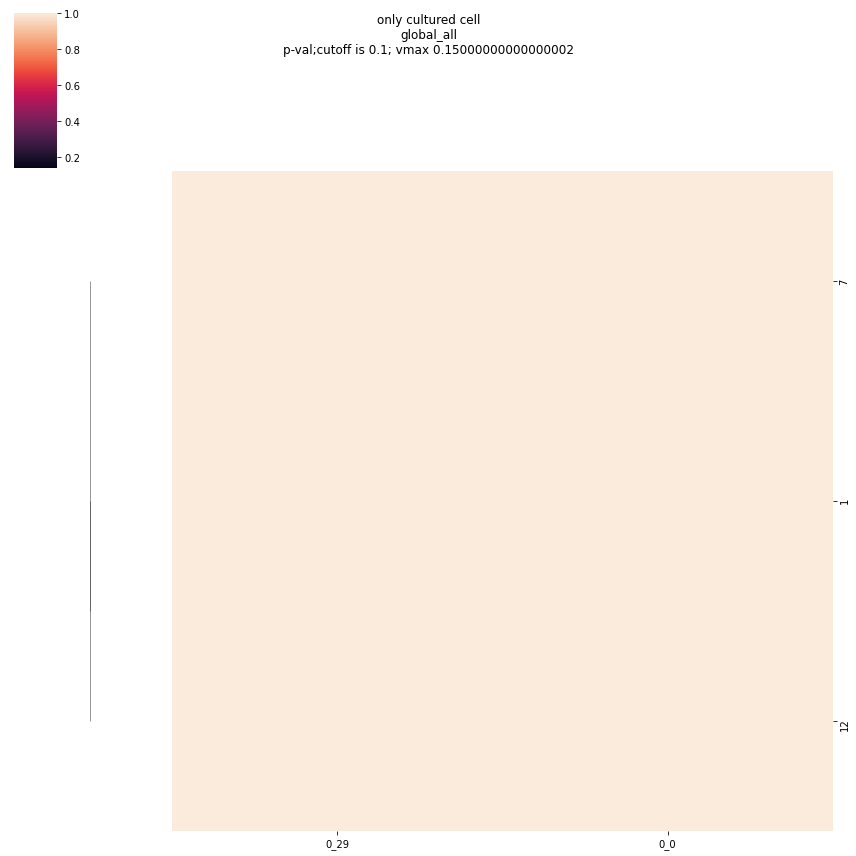

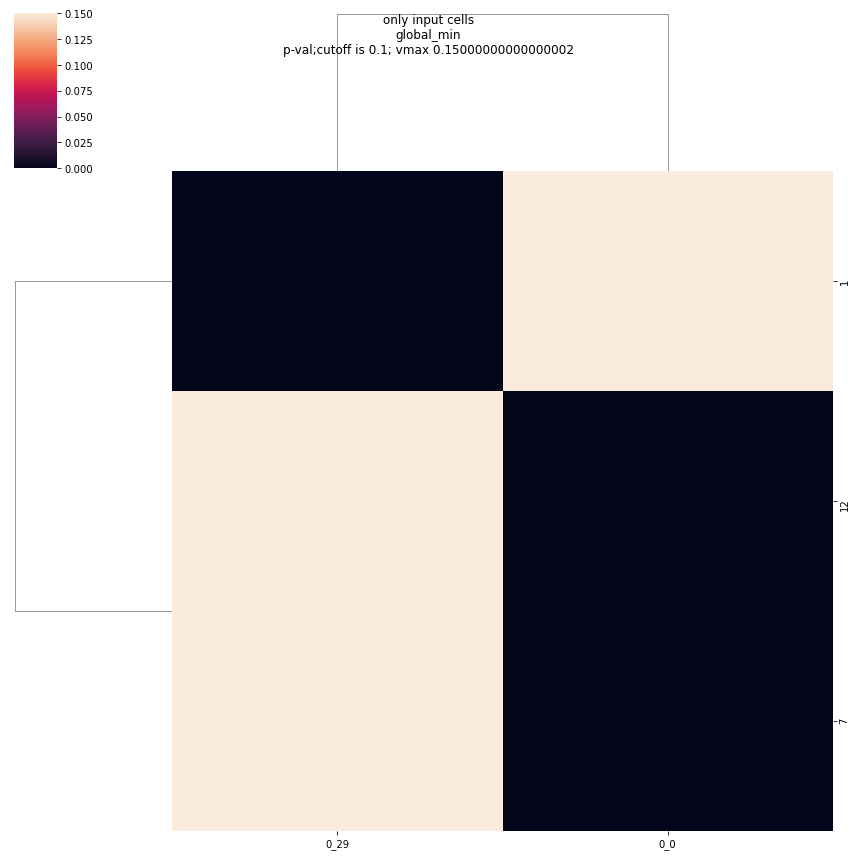

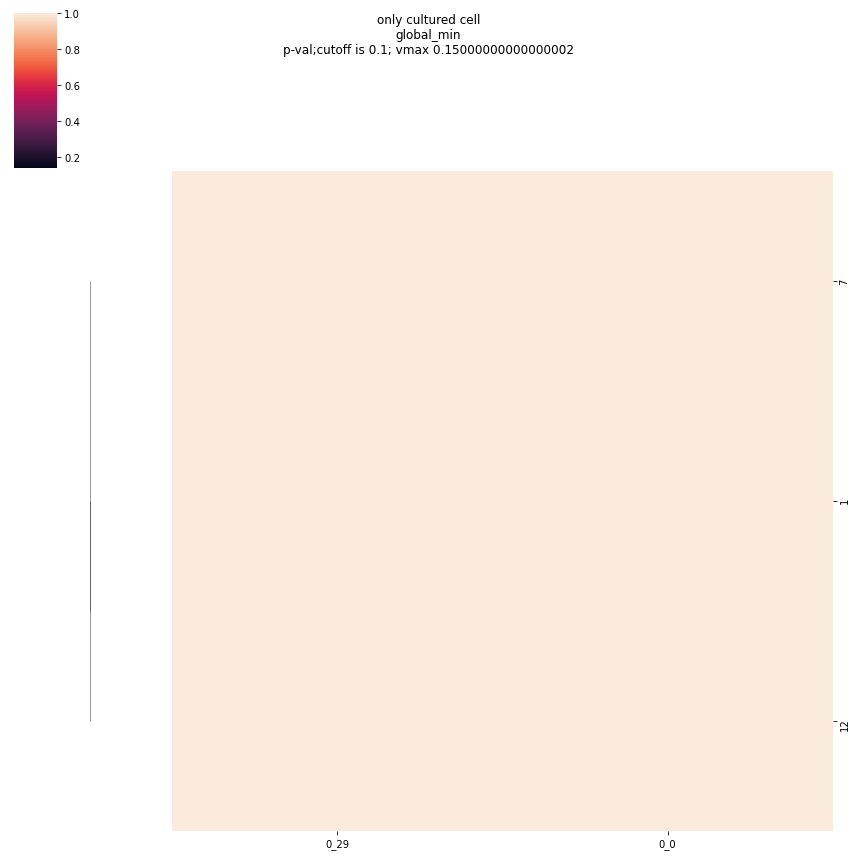

In [17]:
for ind, in_val in input_df[input_df["value"] < p_thresh].groupby("method"):
    print(ind)
    noIn_val = noInput_df.loc[noInput_df["method"] == ind]
    noIn_val = noIn_val.loc[noIn_val["value"]< p_thresh]
    
    noIn_clones = set(noIn_val["index"].values)
    in_clones = set(in_val["index"].values)
    curr_clones = list(noIn_clones.union(in_clones))
    
    noIn_clust = set(noIn_val["variable"].values)
    in_clust = set(in_val["variable"].values)
    curr_clust = list(noIn_clust.union(in_clust))
    
    if (len(curr_clust)==0 or len(curr_clones)==0):
        print('no significant results')
        print(ind)
        continue
     
    
    curr_in_df = pd.DataFrame(index=curr_clones, columns=curr_clust)
    curr_noInput_df = pd.DataFrame(index=curr_clones, columns=curr_clust)

    
    in_val = in_val.set_index(["index", "variable"])
    noIn_val = noIn_val.set_index(["index", "variable"])
    
 
    def get_element_pval(x,y, val):
#         print('val')
#         print(val.head())
        if (y.name, x.name) in val.index:
            return val.loc[(y.name, x.name), "value"]
        else: 
            return 1
         
#     curr_in_df = curr_in_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: in_val.loc[(y.name, x.name), "value"] if (x.name,y.name) in in_val.index else 1, 
#                                                                   axis=1))
    curr_in_df = curr_in_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: get_element_pval(x=x, y=y, val=in_val), axis=1))
    
    curr_noInput_df = curr_noInput_df.apply(lambda x: pd.DataFrame(x).apply(lambda y: get_element_pval(x=x, y=y, val=noIn_val), 
                                                                      axis=1))

    #print(curr_in_df.head())
    
    
    # Transpose both matrices
    curr_noInput_df = curr_noInput_df.transpose()
    curr_in_df = curr_in_df.transpose()
    
    # Plot the input first and then noInput with same clone indices
    
    if (curr_in_df.shape[0] > 1) and (curr_in_df.shape[1] > 1):
        g = sns.clustermap(curr_in_df, vmax=float(p_thresh)+0.05, figsize=(12,12))
        cols = g.dendrogram_col.dendrogram["leaves"]
        g2 = sns.clustermap(curr_noInput_df.iloc[:,cols], col_cluster=False, vmax=float(p_thresh)+0.05, figsize=(12,12))
    else:
        f = plt.figure()
        g = sns.clustermap(curr_in_df, vmax=float(p_thresh)+0.05, row_cluster=False, col_cluster=False)
        g2 = sns.clustermap(curr_noInput_df, vmax=float(p_thresh)+0.05, row_cluster=False, col_cluster=False)

    title = f"{ind}\np-val;cutoff is {p_thresh}; vmax {float(p_thresh)+0.05}"
    g.fig.suptitle("only input cells\n" + title)
    g2.fig.suptitle("only cultured cell\n" + title)
    #g.ax_cbar.set(title=title)  # g.ax_cbar.set(title="-log10 p-value")
    
    g.fig.savefig(join(outdir, f"input_{ind}_shuffle_sig.png"),dpi=300, bbox_inches = "tight")
    
    g2.fig.savefig(join(outdir, f"cultured_{ind}_shuffle_sig.png"),dpi=300, bbox_inches = "tight")
    